# HRD Feature Engineering | BRCA1 & BRCA2

**Objective**: Construct biologically-grounded BRCA-based HRD labels from DepMap cell line data to support downstream analyses of PARP inhibitor sensitivity across relevant cancer models.

---
---
---

## 1. Setup 📦

---
---

In [1]:
# Data Management
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utils
from IPython.display import display, HTML, IFrame, Image
from pathlib import Path

# Settings
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)
sns.set_style('darkgrid', {'grid.color':'0.9','xtick.bottom':True,'ytick.left':True})

## 2. Data Loading ⚙️

**Objective**: Load and organize the curated cell line cohort, DepMap mutation data, and any external HRD-related feature sets.

---
---

In [2]:
# Define project root and file path relative to user OS
BASE_DIR = Path.cwd()
DAMAGING_MUTATIONS_PATH     = BASE_DIR / 'data' / 'OmicsSomaticMutationsMatrixDamaging.csv'
CN_GENE_WGS_PATH            = BASE_DIR / 'data' / 'OmicsCNGeneWGS.csv'
CN_GENE_WGS_LOG_PATH        = BASE_DIR / 'data' / 'PortalOmicsCNGeneLog2.csv'

In [3]:
# Load data into local dataframes (with disabled chunked dtype inference)
damaging_mutations_df       = pd.read_csv(DAMAGING_MUTATIONS_PATH, low_memory=False)
cn_gene_wgs_df              = pd.read_csv(CN_GENE_WGS_PATH, low_memory=False)
cn_gene_wgs_log_df          = pd.read_csv(CN_GENE_WGS_LOG_PATH, low_memory=False)

The original datasets were downloaded from DepMap’s public [portal](https://depmap.org/portal/data_page/?tab=allData).

- **`damaging_mutations_df`**: Contains a gene-level binary matrix indicating the presence of damaging somatic alterations in each cell line. A gene is considered damaged if it harbors at least one likely loss-of-function mutation, as defined by DepMap’s mutation annotation pipeline. This dataset is used to define BRCA-associated HRD.

- **`cn_gene_wgs_df`**: Contains gene-level relative copy number values derived from WGS for each cell line. This dataset can be used alongside damaging mutation calls to identify allele loss events (e.g., LOH) in BRCA1/2, enabling the distinction between partial and full HRD.

- **`cn_gene_wgs_log_df`**: A log2(x+1) transformed version of `cn_gene_wgs_df` (OmicsCNGene.csv). 

This project aims to systematically examine how multiple definitions of HRD relate to drug response across all PARP inhibitors available in the dataset. So each of the HRD feature engineering notebooks will derive homologous recombination deficiency (HRD) status using one of three complementary strategies: (1) BRCA1/2 double-hit alteration status, (2) computed genomic scar–based HRD scores, and (3) COSMIC mutational signatures. These engineered features will then be harmonized with PARP inhibitor AUC measurements to generate a modeling-ready dataset for downstream statistical analysis and predictive modeling of HRD-associated drug response. This notebook will focus on **BRCA-derived HRD status**.

## 3. BRCA1 & BRCA2 Alterations [HRD Component 1] 🧬

**Objective**: Identify and encode BRCA1/2 alterations, including damaging mutations and copy number loss, to define the first component of HRD for downstream feature engineering and integration with PARPi response. 

**Methodology**: First, damaging somatic mutations are extracted from mutation matrices to identify potential loss-of-function events. Second, gene-level copy number values are obtained and log2-transformed to normalize distributions and facilitate thresholding. Third, gene-specific thresholds are calculated using a standard-deviation approach to define loss-of-heterozygosity (LOH) and homozygous deletion events. Fourth, double-hit status is assigned for cell lines with a damaging mutation co-occurring with a copy number loss below the LOH threshold. Fifth, homozygous deletion flags are generated for extreme copy number losses below the deep deletion threshold. Finally, both mechanisms are integrated into a single BRCA-HRD feature, capturing all evidence of BRCA inactivation while keeping mechanisms distinct for interpretability.

---
---

**BRCA1** and **BRCA2** are core components of the **homologous recombination** (**HR**) DNA repair pathway, which mediates high-fidelity repair of double-strand DNA breaks. Loss-of-function alterations resulting in biallelic inactivation of either gene impair HR activity, leading to **homologous recombination deficiency** (**HRD**). Tumors with BRCA-associated HRD accumulate characteristic patterns of genomic instability and are particularly sensitive to PARP inhibition, making BRCA mutation status one of the most clincally validated biomarkers of HRD.

Biallelic inactivation refers to the loss of function of both alleles of a tumor suppressor gene within a given cell. Because BRCA1 and BRCA2 act as tumor suppressors, inactivation of a single allele is generally insufficient to fully abrogate homologous recombination; instead, both copies must be inactivated to produce a clear-cut HR-deficient phenotype. This “two-hit” state can arise through several mechanisms:
1) A germline pathogenic mutation in one allele accompanied by loss of heterozygosity (LOH) of the remaining wild-type allele.
2) A somatic mutation in one allele accompanied by loss of heterozygosity (LOH) of the remaining wild-type allele.
3) Two independent somatic mutations affecting each allele (much less common).
4) Homozygous deletion of the gene.
5) Promoter hypermethylation or other epigenetic silencing serving as a second hit (more commonly observed for BRCA1).

In this project, not all five mechanisms can be comprehensively captured due to data limitations. DepMap does not reliably distinguish germline from somatic mutation origin, so germline+LOH and somatic+LOH scenarios are operationally indistinguishable and will be treated equivalently as mutation-associated biallelic inactivation. Promoter methylation is also not available in the public DepMap resources and will therefore be excluded.

With the available datasets, two mechanisms can be systematically approximated:

- **Somatic mutation + copy number loss (LOH)**, identified by integrating the damaging mutation matrix with gene-level copy number values from WGS.
- **Homozygous deletion**, inferred from sufficiently low gene-level copy number values independent of mutation status.

These structural events will be derived from `damaging_mutations_df` and `cn_gene_wgs_df` to construct a reproducible proxy for BRCA biallelic inactivation.

**Note**: HRD can also arise from alterations in other homologous recombination repair (HRR) genes. However, this section focuses exclusively on BRCA1 and BRCA2 as canonical and clinically validated determinants of HRD. Other HRR genes (e.g., RAD51, PALB2) may be explored in future iterations of this notebook.

[Source](https://pmc.ncbi.nlm.nih.gov/articles/PMC10581613/)

### 3a. Extract damaging mutation and copy number info for BRCA1/2.

---

In [4]:
# List all columns that contain 'BRCA' in their name
brca_cols_dmg = [col for col in damaging_mutations_df.columns if 'BRCA' in col]
print(brca_cols_dmg)
brca_cols_cn = [col for col in cn_gene_wgs_df.columns if 'BRCA' in col]
print(brca_cols_cn)
brca_cols_cn_log = [col for col in cn_gene_wgs_log_df.columns if 'BRCA' in col]
print(brca_cols_cn_log)

['BRCA2 (675)', 'BRCA1 (672)']
['BRCA1 (672)', 'BRCA2 (675)']
['BRCA1 (672)', 'BRCA2 (675)']


In [5]:
# Subset damaging mutations
brca_mutations_df = damaging_mutations_df[['ModelID'] + brca_cols_dmg].copy()

# Subset copy number
brca_cn_df = cn_gene_wgs_df[['ModelID'] + brca_cols_cn].copy()

# Subset log2 version of copy number data
cn_gene_wgs_log_df.rename(columns={'Unnamed: 0': 'ModelID'}, inplace=True)
brca_cn_log2_df = cn_gene_wgs_log_df[['ModelID'] + brca_cols_cn_log].copy()

In [6]:
# Merge mutation and copy number data for BRCA1/2
brca_df = brca_mutations_df.merge(
    brca_cn_df,
    on='ModelID',
    suffixes=('_mut', '_cn'),
    how='inner'  
)
brca_df = brca_df.merge(
    brca_cn_log2_df,
    on='ModelID',
    suffixes=(),
    how='left'  
)


# Replace column names for convenience
brca_df = brca_df.rename(columns={
    'BRCA1 (672)_mut': 'BRCA1_damaging',    
    'BRCA2 (675)_mut': 'BRCA2_damaging', 
    'BRCA1 (672)_cn': 'BRCA1_cnloss', 
    'BRCA2 (675)_cn': 'BRCA2_cnloss',
    'BRCA1 (672)': 'BRCA1_cnloss_log2', 
    'BRCA2 (675)': 'BRCA2_cnloss_log2'
})

brca_df

,ModelID,BRCA2_damaging,BRCA1_damaging,BRCA1_cnloss,BRCA2_cnloss,BRCA1_cnloss_log2,BRCA2_cnloss_log2
0,ACH-000062,0.0,0.0,0.910328,0.888935,0.933821,0.917573
1,ACH-001949,1.0,0.0,1.273167,1.218637,1.184704,1.149673
2,ACH-002059,0.0,0.0,1.127715,1.089594,1.089305,1.063223
3,ACH-000402,0.0,0.0,1.192607,1.012864,1.132647,1.009250
4,ACH-000693,0.0,0.0,1.115932,0.834393,1.081293,0.875303
...,...,...,...,...,...,...,...
2107,ACH-001075,0.0,0.0,1.009806,1.005819,1.007056,1.004192
2108,ACH-001096,0.0,0.0,1.050272,0.993736,1.035815,0.995474
2109,ACH-001818,0.0,0.0,0.983741,1.005730,0.988223,1.004127
2110,ACH-000313,0.0,0.0,0.920102,0.560798,0.941183,0.642284


BRCA1 and BRCA2 columns were extracted from the somatic damaging mutation and copy number matrices to focus exclusively on these key determinants of HRD, preparing the data for defining partial (single allele affected) versus full (double-hit: mutation plus LOH) HRD calls. With the available data, biallelic inactivation can be approximated by combining damaging mutation calls with copy number loss to detect mutation + LOH events, or by identifying very low copy number values to capture homozygous deletions.

### 3b. Validate BRCA mutation data and copy number distributions

---

In [7]:
# Inspect BRCA damaging mutation columns
print('BRCA damaging mutation value counts:')
print(brca_df[['BRCA1_damaging', 'BRCA2_damaging']].apply(pd.Series.value_counts, dropna=False))
print('\nMissing values in damaging mutation columns:')
print(brca_df[['BRCA1_damaging', 'BRCA2_damaging']].isna().sum())

# Inspect BRCA copy number columns
print('\nBRCA copy number summary statistics:')
print(brca_df[['BRCA1_cnloss', 'BRCA2_cnloss']].describe())
print('\nMissing values in copy number columns:')
print(brca_df[['BRCA1_cnloss', 'BRCA2_cnloss']].isna().sum())

# Inspect log2 version
print('\nBRCA log2 statistics:')
print(brca_df[['BRCA1_cnloss_log2', 'BRCA2_cnloss_log2']].describe())
print('\nMissing values in log2 version:')
print(brca_df[['BRCA1_cnloss_log2', 'BRCA2_cnloss_log2']].isna().sum())

# Count cell lines with at least one damaging BRCA mutation
num_with_damage = brca_df[(brca_df['BRCA1_damaging'] == 1) | (brca_df['BRCA2_damaging'] == 1)].shape[0]
print(f'\nCell lines with at least one damaging BRCA mutation: {num_with_damage}')

BRCA damaging mutation value counts:
     BRCA1_damaging  BRCA2_damaging
0.0            2076            2035
1.0              22              67
2.0              14              10

Missing values in damaging mutation columns:
BRCA1_damaging    0
BRCA2_damaging    0
dtype: int64

BRCA copy number summary statistics:
       BRCA1_cnloss  BRCA2_cnloss
count   2112.000000   2112.000000
mean       1.079656      0.981626
std        0.275112      0.301701
min        0.472583      0.190439
25%        0.981369      0.779931
50%        1.045594      0.993465
75%        1.161506      1.070254
max        9.395696      4.457176

Missing values in copy number columns:
BRCA1_cnloss    0
BRCA2_cnloss    0
dtype: int64

BRCA log2 statistics:
       BRCA1_cnloss_log2  BRCA2_cnloss_log2
count        2112.000000        2112.000000
mean            1.047471           0.971105
std             0.148636           0.204420
min             0.558349           0.251494
25%             0.986026           0.831821


The BRCA1 and BRCA2 damaging mutation columns were inspected and found to contain primarily wild-type calls (0), with a smaller number of cell lines harboring one or more damaging events (1 or 2). No missing values were observed in these columns. 

Copy number distributions for BRCA1 and BRCA2 were continuous, with minima indicating potential deep deletions (<0.7) and maxima reflecting occasional outliers. Again, no missing values were present. 

In total, 86 cell lines harbor at least one damaging BRCA mutation, representing the initial pool of potential double-hit candidates for HRD feature engineering.

### 3c. Derive CN thresholds for LOH & homozygous deletion.

---

Based on the validation checks, the distributions of BRCA1 and BRCA2 copy number values have noticeable differences. Using a single threshold across both genes could misclassify loss-of-heterozygosity (LOH) events, either underestimating true biallelic inactivation or inflating false positives. Therefore, gene-specific thresholds for CN loss will be determined empirically from the data before defining BRCA1/2 double-hit status. This ensures that the resulting HRD calls are biologically grounded and reflect the distinct copy number landscapes of each gene.

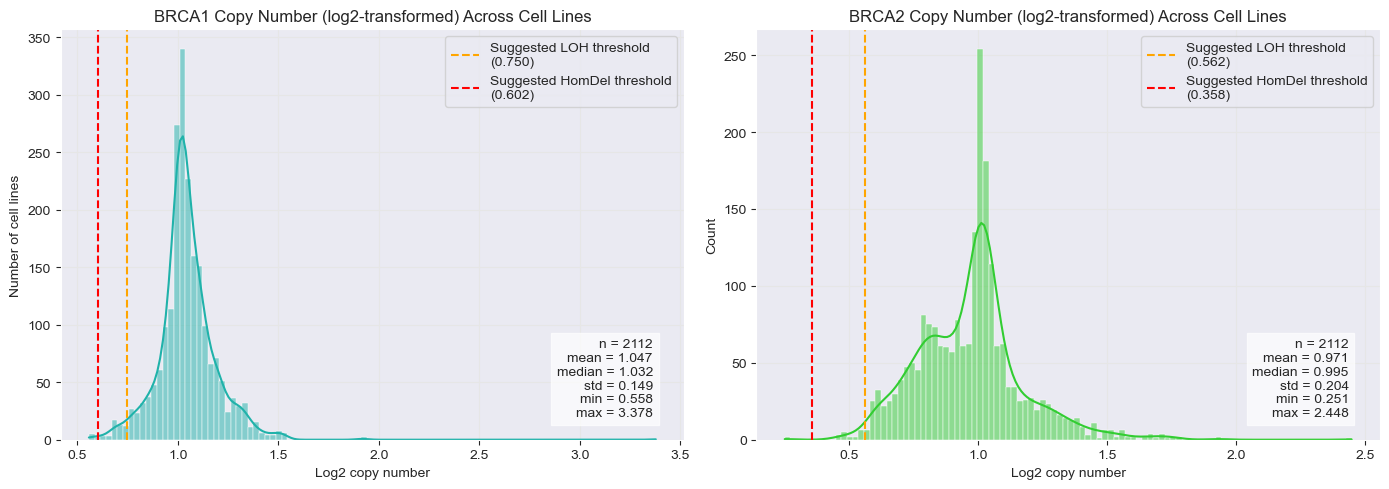

In [8]:
# Define a std-based example threshold (mean - 2*std) for LOH
brca1_loh_thresh = brca_df['BRCA1_cnloss_log2'].mean() - 2*brca_df['BRCA1_cnloss_log2'].std()
brca2_loh_thresh = brca_df['BRCA2_cnloss_log2'].mean() - 2*brca_df['BRCA2_cnloss_log2'].std()

# Define a std-based example threshold (mean - 3*std) for deep deletions
brca1_homdel_thresh = brca_df['BRCA1_cnloss_log2'].mean() - 3*brca_df['BRCA1_cnloss_log2'].std()
brca2_homdel_thresh = brca_df['BRCA2_cnloss_log2'].mean() - 3*brca_df['BRCA2_cnloss_log2'].std()


# Set up figure
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)


### BRCA1 log2 CN
sns.histplot(brca_df['BRCA1_cnloss_log2'], bins=100, kde=True, ax=axes[0], color='lightseagreen')
axes[0].axvline(brca1_loh_thresh, color='orange', linestyle='--', label=f'Suggested LOH threshold\n({brca1_loh_thresh:.3f})')
axes[0].axvline(brca1_homdel_thresh, color='red', linestyle='--', label=f'Suggested HomDel threshold\n({brca1_homdel_thresh:.3f})')
axes[0].set_title('BRCA1 Copy Number (log2-transformed) Across Cell Lines')
axes[0].set_xlabel('Log2 copy number')
axes[0].set_ylabel('Number of cell lines')

# Add summary stats for BRCA1 data
summary_text_1 = (f"n = {brca_df['BRCA1_cnloss_log2'].count()}\n"
                  f"mean = {brca_df['BRCA1_cnloss_log2'].mean():.3f}\n"
                  f"median = {brca_df['BRCA1_cnloss_log2'].median():.3f}\n"
                  f"std = {brca_df['BRCA1_cnloss_log2'].std():.3f}\n"
                  f"min = {brca_df['BRCA1_cnloss_log2'].min():.3f}\n"
                  f"max = {brca_df['BRCA1_cnloss_log2'].max():.3f}")
axes[0].text(0.95, 0.05, summary_text_1, transform=axes[0].transAxes,
             ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
axes[0].legend()


### BRCA2 log2 CN
sns.histplot(brca_df['BRCA2_cnloss_log2'], bins=100, kde=True, ax=axes[1], color='limegreen')
axes[1].axvline(brca2_loh_thresh, color='orange', linestyle='--', label=f'Suggested LOH threshold\n({brca2_loh_thresh:.3f})')
axes[1].axvline(brca2_homdel_thresh, color='red', linestyle='--', label=f'Suggested HomDel threshold\n({brca2_homdel_thresh:.3f})')
axes[1].set_title('BRCA2 Copy Number (log2-transformed) Across Cell Lines')
axes[1].set_xlabel('Log2 copy number')

# Add summary stats for BRCA2 data
summary_text_2 = (f"n = {brca_df['BRCA2_cnloss_log2'].count()}\n"
                  f"mean = {brca_df['BRCA2_cnloss_log2'].mean():.3f}\n"
                  f"median = {brca_df['BRCA2_cnloss_log2'].median():.3f}\n"
                  f"std = {brca_df['BRCA2_cnloss_log2'].std():.3f}\n"
                  f"min = {brca_df['BRCA2_cnloss_log2'].min():.3f}\n"
                  f"max = {brca_df['BRCA2_cnloss_log2'].max():.3f}")
axes[1].text(0.95, 0.05, summary_text_2, transform=axes[1].transAxes,
             ha='right', va='bottom', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

axes[1].legend()

plt.tight_layout()
plt.show()

The log2-transformed copy number data is used because it centers neutral diploid values around ~1 (this dataset isn’t in the standard log2 ratios around 0), compresses outliers, and better accommodates gene-specific variability than raw CN values.

The distributions demonstrate clear gene-specific differences in central tendency and spread:
- **BRCA1** shows a tighter distribution centered slightly above 1.0, with lower variance and a narrower interquartile range.
- **BRCA2** exhibits greater variability, a broader lower tail, and a lower minimum value, suggesting more pronounced copy number losses in a subset of cell lines.

These differences confirm that applying a single universal threshold to define copy number loss (or LOH) across both genes would be inappropriate and may lead to systematic misclassification.

To systematically define potential LOH events, a gene-specific, standard-deviation-based threshold was applied, defining LOH as log2 copy number values below **mean - 2*std**. This accounts for natural variability while highlighting true outlier losses likely to reflect loss of a single BRCA allele. For this dataset, the LOH thresholds are approximately 0.749 for BRCA1 and 0.562 for BRCA2.

To capture extreme copy number loss consistent with potential homozygous deletion, stricter, gene-specific thresholds were calculated as **mean − 3*std**, yielding approximately 0.602 for BRCA1 and 0.358 for BRCA2. These thresholds can be used to flag cell lines with severe deletions, independent of damaging mutations.

In [9]:
# Flag potential LOH events using 2*std threshold
brca_df['BRCA1_loh_flag'] = (brca_df['BRCA1_cnloss_log2'] < brca1_loh_thresh).astype(int)
brca_df['BRCA2_loh_flag'] = (brca_df['BRCA2_cnloss_log2'] < brca2_loh_thresh).astype(int)

# Flag potential homozygous deletions using 3*std threshold
brca_df['BRCA1_homdel_flag'] = (brca_df['BRCA1_cnloss_log2'] < brca1_homdel_thresh).astype(int)
brca_df['BRCA2_homdel_flag'] = (brca_df['BRCA2_cnloss_log2'] < brca2_homdel_thresh).astype(int)

# Examine number of flags for each
brca_df[['BRCA1_loh_flag','BRCA2_loh_flag','BRCA1_homdel_flag','BRCA2_homdel_flag']].sum()

BRCA1_loh_flag       52
BRCA2_loh_flag       22
BRCA1_homdel_flag     5
BRCA2_homdel_flag     2
dtype: int64

Because there is no standardized copy number classification framework specific to DepMap cancer cell line data, a gene-specific, standard-deviation–based thresholding approach was adopted. This method adapts to each gene’s empirical distribution and captures both moderate copy number reductions (putative LOH) and extreme losses (putative homozygous deletions) for downstream BRCA double-hit HRD classification.

Using this approach, 52 BRCA1 LOH candidates and 22 BRCA2 LOH candidates were identified across the cell line cohort. These events must be evaluated in conjunction with somatic damaging mutation status to determine true biallelic inactivation (“double-hit”) and assign BRCA-based HRD labels.

For homozygous deletions, 7 total events were identified. Because deep deletions typically reflect loss of both alleles, these events represent strong candidates for biallelic inactivation and will be classified as BRCA-driven HRD, subject to manual verification of copy number quality metrics.

<br/>

An [alternative approach](https://forum.depmap.org/t/defining-deep-deletions-and-amplifications/710/5) based on converting DepMap CN values to log2 ratios relative to diploid and applying fixed GISTIC-style thresholds was also evaluated. However, this method is not well suited to the present dataset. DepMap WGS gene-level CN values are log2-transformed and normalized in a dataset-specific manner, and do not correspond directly to an absolute diploid baseline of two copies. Applying fixed thresholds derived from theoretical diploid assumptions risks systematic misclassification and inflation of LOH or deep deletion calls.

Accordingly, gene-specific thresholds derived from the observed BRCA1 and BRCA2 log2 CN distributions provide a more appropriate and internally consistent strategy. This approach accounts for the empirical variability and central tendency of each gene, ensuring that flagged events reflect meaningful relative copy number reductions rather than artifacts of platform scaling or normalization.

### 3d. Extract BRCA1/2 double-hit status via somatic mutation + LOH.

---

The next step is to integrate damaging mutation and copy number data to identify BRCA1 and BRCA2 “double-hit” events using the derived gene-specific thresholds. A double-hit represents biallelic inactivation of the gene. Operationally, this is defined as the presence of a damaging mutation together with copy number loss consistent with LOH, indicating loss of the remaining functional allele. This distinguishes monoallelic alteration from true biallelic loss required to produce a homologous recombination–deficient phenotype.

In [10]:
# BRCA1 double-hit: damaging mutation + CN value below LOH threshold
brca_df['BRCA1_double_hit'] = (
    (brca_df['BRCA1_damaging'] >= 1) &
    (brca_df['BRCA1_loh_flag'] == 1)
).astype(int)

# BRCA2 double-hit: damaging mutation + CN value below LOH threshold
brca_df['BRCA2_double_hit'] = (
    (brca_df['BRCA2_damaging'] >= 1) &
    (brca_df['BRCA2_loh_flag'] == 1)
).astype(int)

# Combined BRCA double-hit flag
brca_df['BRCA_double_hit'] = (
    (brca_df['BRCA1_double_hit'] == 1) |
    (brca_df['BRCA2_double_hit'] == 1)
).astype(int)

# Inspect counts
print(brca_df[['BRCA1_double_hit', 'BRCA2_double_hit', 'BRCA_double_hit']].apply(
    pd.Series.value_counts).fillna(0).astype(int))

   BRCA1_double_hit  BRCA2_double_hit  BRCA_double_hit
0              2107              2112             2107
1                 5                 0                5


BRCA double-hit events are defined as the co-occurrence of a damaging mutation and copy number loss below the gene-specific LOH threshold for either BRCA1 or BRCA2. Individual flags (`BRCA1_double_hit` and `BRCA2_double_hit`) capture gene-specific biallelic inactivation, while the combined `BRCA_double_hit` feature identifies cell lines with loss of function in at least one BRCA gene.

In the current dataset, **5 / 2112** cell lines meet the double-hit criteria, all involving BRCA1. No BRCA2 double-hit events were observed under the applied thresholds. This low frequency is consistent with the relative rarity of BRCA-associated homologous recombination deficiency within this broad cell line panel.

### 3e. Extract BRCA1/2 HRD status via homozygous deletion (Deep Deletion)

---

In [11]:
# Combine BRCA HRD via homozygous deletion
brca_df['BRCA_homdel'] = (
    (brca_df['BRCA1_homdel_flag'] == 1) |
    (brca_df['BRCA2_homdel_flag'] == 1)
).astype(int)

# Inspect counts
print(brca_df[['BRCA1_homdel_flag', 'BRCA2_homdel_flag', 'BRCA_homdel']].apply(
    pd.Series.value_counts).fillna(0).astype(int)
)

   BRCA1_homdel_flag  BRCA2_homdel_flag  BRCA_homdel
0               2107               2110         2105
1                  5                  2            7


Binary flags (`BRCA1_homdel_flag` and `BRCA2_homdel_flag`) identify cell lines with extreme copy number loss consistent with complete allelic deletion. These flags were combined into a `BRCA_homdel` feature capturing cell lines harboring a homozygous deletion in either BRCA gene.

In the current dataset, **7 / 2112** cell lines meet criteria for homozygous deletion–associated HRD. Specifically, 5 involve BRCA1 and 2 involve BRCA2. As expected, these events are rare and represent the most extreme copy number losses within the distribution.

### 3f. Define unified BRCA-HRD status.

---

In [12]:
# Combine available mechanisms (mutation+LOH and deep deletion) into single HRD status
brca_df['BRCA_HRD'] = (
    (brca_df['BRCA_double_hit'] == 1) |
    (brca_df['BRCA_homdel'] == 1)
).astype(int)

# Inspect final counts
print(brca_df['BRCA_HRD'].value_counts())

BRCA_HRD
0    2100
1      12
Name: count, dtype: int64


In [13]:
# Check independence of double hit vs deep deletion
pd.crosstab(brca_df['BRCA_double_hit'], brca_df['BRCA_homdel'])

BRCA_homdel,0,1
BRCA_double_hit,,
0,2100,7
1,5,0


The final HRD feature integrates both BRCA-associated inactivation mechanisms observed in this dataset:
- **Double-hit (somatic damaging mutation + LOH)**: Captures cell lines with at least one damaging BRCA1 or BRCA2 mutation combined with a copy number loss below the gene-specific LOH threshold. In this dataset, **5 cell lines** meet this criteria.
- **Homozygous deletion**: Captures cell lines with extreme copy number loss (below the gene-specific deep deletion threshold) in either BRCA1 or BRCA2. Here, **7 cell lines** are flagged.

A cross-tabulation confirms that these mechanisms are mutually exclusive in the current dataset, with 0 cell lines exhibiting both double-hit and homozygous deletion. Combining the two flags into a single `BRCA_HRD` feature results in **12 / 2112** cell lines classified as HRD-positive. This approach ensures that all available evidence of BRCA loss is captured while keeping the mechanisms distinct and interpretable for downstream analyses.

## 4. Summary & Export 💾 

---
---

In [14]:
# Export merged data as reusable pickle file for HRD feature engineering
brca_df.to_pickle(BASE_DIR / 'utils' / 'brca_df.pkl')

brca_df

,ModelID,BRCA2_damaging,BRCA1_damaging,BRCA1_cnloss,BRCA2_cnloss,BRCA1_cnloss_log2,BRCA2_cnloss_log2,BRCA1_loh_flag,BRCA2_loh_flag,BRCA1_homdel_flag,BRCA2_homdel_flag,BRCA1_double_hit,BRCA2_double_hit,BRCA_double_hit,BRCA_homdel,BRCA_HRD
0,ACH-000062,0.0,0.0,0.910328,0.888935,0.933821,0.917573,0,0,0,0,0,0,0,0,0
1,ACH-001949,1.0,0.0,1.273167,1.218637,1.184704,1.149673,0,0,0,0,0,0,0,0,0
2,ACH-002059,0.0,0.0,1.127715,1.089594,1.089305,1.063223,0,0,0,0,0,0,0,0,0
3,ACH-000402,0.0,0.0,1.192607,1.012864,1.132647,1.009250,0,0,0,0,0,0,0,0,0
4,ACH-000693,0.0,0.0,1.115932,0.834393,1.081293,0.875303,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2107,ACH-001075,0.0,0.0,1.009806,1.005819,1.007056,1.004192,0,0,0,0,0,0,0,0,0
2108,ACH-001096,0.0,0.0,1.050272,0.993736,1.035815,0.995474,0,0,0,0,0,0,0,0,0
2109,ACH-001818,0.0,0.0,0.983741,1.005730,0.988223,1.004127,0,0,0,0,0,0,0,0,0
2110,ACH-000313,0.0,0.0,0.920102,0.560798,0.941183,0.642284,0,0,0,0,0,0,0,0,0


This notebook defines **BRCA1/2-based HRD** as the first component of HRD profiling that will be used in this project.

Damaging mutation and gene-level copy number data for BRCA1 and BRCA2 were extracted and validated, including log2-transformed CN values to account for gene-specific variability. Gene-specific thresholds were calculated to identify **loss-of-heterozygosity (LOH)** events and **homozygous deletions**. Using these thresholds, cell lines with **double-hit events** (somatic damaging mutation + LOH) and **homozygous deletions** were flagged separately, then combined into a final ``BRCA_HRD` feature. Other mechanisms of BRCA-associated HRD, such as two independent somatic mutations or promoter hypermethylation, were not assessed due to lack of available data.

Out of 2112 cell lines, BRCA-associated HRD is rare: only 12 cell lines meet either double-hit or homozygous deletion criteria, reflecting the scarcity of biallelic inactivation of BRCA1/2 in this panel.

The merged `brca_df` containing all BRCA1/2 features (including damaging mutation calls, copy number values, log2-transformed CN, and all derived flags) is exported as a pickle file. This preserves the dataset in a ready-to-use format for downstream HRD feature engineering and can be pruned later for the primary `BRCA_HRD` feature when needed.

Not all HRD is driven by BRCA1/2 mutations. Defects in other components of the homologous recombination pathway can similarly compromise DNA repair, leading to characteristic patterns of chromosomal instability (i.e., **genomic scars**). Although canonical genomic scar scores are not available via DepMap, related metrics such as **loss of heterozygosity** (**LOH**), **chromosomal instability** (**CIN**), **whole-genome doubling** (**WGD**), and **aneuploidy** capture these patterns. These features were already extracted from the Omics Global Signatures dataset, and therefore will serve as proxies to detect HRD in BRCA wild-type cell lines.

In this section, these metrics will be integrated into a composite score to define a binary HRD label (`proxy_HRD_status`), in order to identify cell lines that lack BRCA mutations but still exhibit HRD-like genomic instability patterns.


### 4a. Extract genomic scar metrics.

---

In [15]:
# Subset relevant genomic scar metrics
scar_metrics = ['LoHFraction', 'CIN', 'WGD', 'Aneuploidy']
genomic_scar_df = omics_signatures_df[['ModelID'] + scar_metrics].copy()

genomic_scar_df.info()

NameError: name 'omics_signatures_df' is not defined

The four relevant scar metrics were extracted above for each cell line. However, only 2582 of the 3021 models (~14%) contained complete information. The remaining missing records must be addressed before standardizing these features to create a composite HRD score. Following the framework outlined by *[Little & Rubin (1987)](https://stefvanbuuren.name/fimd/sec-MCAR.html)*, the mechanism of missingness was assessed. Since the same cell line models are missing values across all four metrics, the data is most consistent with a *Missing at Random (MAR)* scenario due to assay availability. Therefore, imputation is required to mitigate any potential bias.

A deeper look into the distributions of these features will be useful to determine the proper steps for imputing missing data and creating a composite score. 

### 4b. Execute preprocessing measures for each metric.

---

In [ ]:
# Set up figure & individual subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8), 
    layout='constrained', gridspec_kw={'hspace': 0.25})
axs = axs.flatten()  # for easy indexing
rc_palettes = ['Set1', 'Set2', 'viridis', 'pastel']

# Plot raincloud for each metric
for i, metric in enumerate(scar_metrics):
    cloud = pt.RainCloud(
        data=genomic_scar_df,
        y=metric,
        bw=0.2,
        alpha=0.65,
        rain_alpha=0.5,
        width_viol=0.6,
        orient='h',
        palette=rc_palettes[i],
        hue=i,
        ax=axs[i],
    )
    
    # Label quartiles
    desc_stats = genomic_scar_df[[metric]].quantile(q=[0, 0.25, 0.5, 0.75, 1])
    for stat in desc_stats[metric]:
        cloud.text(
            s=f"{stat:.2f}",
            x=stat,
            y=0.16,
            ha='center',
            size='small',
            color='black',
            weight='semibold',
            bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
        )


**Observations:**

`LoHFraction`

- Right-skewed distribution with most observations concentrated at low values 
- Small sample of outliers with high loss of heterozygosity (up to ~0.93)
- Median: 0.20, IQR: 0.08 - 0.33

`CIN`

- Broadly distributed with an overall left skew (peak near the 75th percentile)
- Values mostly concentrated in two areas: above the median and below the 25th percentile
- More variability compared to LoHFraction, but fewer extreme outliers indicating substantial chromosomal instability across many samples, rather than being confined to a small subset
- Median: 0.54, IQR: 0.27 - 0.66

`WGD`

- Binary (0 or 1) distribution, representing the presense / absence of whole-genome duplication
- Most samples show WGD, with only a smaller subset at the 0 mark (Median: 1)

`Aneuploidy`

- Discrete, integer-valued distribution reflecting whole chromosome or chromosome-arm alterations
- Broadly distributed with an asymmetric shape, peaking between the median and 75th percentile
- Declines sharply toward higher values, with a broader shoulder toward lower aneuploidy 
- Median: 19, IQR: 8 - 24

Overall, these genomic instability metrics exhibit markedly different distributions. Loss of heterozygosity is generally low, with rare extreme values, while CIN and Aneuploidy show broader, more continuous variation across samples. These patterns suggest that genomic instability arises through multiple, partially independent mechanisms, with different samples showing distinct dominant instability patterns.

Given these distributional characteristics, missing data should be imputed using the median to mitigate the influence of skew and outliers. Additionally, when combining these metrics into a composite score, standardization (via scaling techniques) is essential to account for their differing distributions and ranges.

In [ ]:
# Impute missing values with median for each scar metric
genomic_scar_df[scar_metrics] = genomic_scar_df[scar_metrics].fillna(
    genomic_scar_df[scar_metrics].median())

### 4c. Scale each metric to prepare for integration into singular feature.

---

In [ ]:
# Fit and transform the four scar metrics
scaler = StandardScaler()
scaled_values = scaler.fit_transform(genomic_scar_df[scar_metrics].copy())

# Create new scaled columns
scaled_col_names = [f'z_{col}' for col in scar_metrics]
scaled_genomic_scar_df = genomic_scar_df.copy()
scaled_genomic_scar_df[scaled_col_names] = scaled_values

scaled_genomic_scar_df.head()

The genomic scar metrics span different numerical ranges and distributional shapes, so they must be placed on a common scale before being combined into a composite metric. Each feature was therefore standardized using z-score normalization, allowing values to represent how extreme a cell line is relative to the overall population. This approach prevents any single metric from dominating the composite score solely due of its magnitude, while still preserving biologically meaningful variation across samples.

Alternative approaches, such as robust scaling, were considered here due to the presence of extreme outliers in some metrics. However, because the primary goal is to capture relative deviation from the cohort mean rather than attentuate extremes, z-scoring was deemed more appropriate. Although robust scalers reduce the influence of outliers and are useful for noise control, the high values observed here likely represent true biological signals associated with HRD. Moreover, the large sample size, combined with prior median-based imputation, further mitigates outlier influence already, further strengthening the case for a standard scalar. 

Standardization centers each genomic scar metric at the cohort mean and expresses values in units of standard deviation. Under this transformation, a value of zero represents the average level of genomic instability, positive values indicate above-average scar burden, and negative values indicate below-average burden.

This transformation enables direct comparison and aggregation across variables that originally differed in scale, range, and distribution. For the binary WGD column, z-score normalization simply maps absence to below-average instability and presence to above-average instability, preserving its biological interpretation while allowing it to contribute proportionally to the composite score.

With all four genomic scar metrics placed on a common scale, they can now be integrated into a single composite feature representing genomic scar–based HRD.

### 4d. Integrate genomic scar metrics into singular scar-based HRD score.

---

In [ ]:
# Compute composite HRD score using mean of the scaled data
scaled_genomic_scar_df['HRD_proxy_genomic_score'] = scaled_genomic_scar_df[scaled_col_names].mean(axis=1)

scaled_genomic_scar_df[['ModelID', 'HRD_proxy_genomic_score']].head()

The standardized genomic scar metrics were averaged to generate a continuous composite HRD score. Because each feature is expressed in units of standard deviation, this approach ensures equal contribution from all metrics without allowing any single feature to dominate due to scale differences. Higher values correspond to greater overall genomic instability consistent with homologous recombination deficiency.

In [ ]:
# Set up figure for composite score
plt.figure(figsize=(8, 4))

# Plot raincloud for composite metric
composite_cloud = pt.RainCloud(
    data=scaled_genomic_scar_df,
    y='HRD_proxy_genomic_score',
    bw=0.2,
    alpha=0.45,
    rain_alpha=0.5,
    width_viol=0.6,
    orient='h',
    palette='Set1',
    hue=0,
)

# Label quartiles
composite_desc_stats = scaled_genomic_scar_df[['HRD_proxy_genomic_score']].quantile(q=[0, 0.25, 0.5, 0.75, 1])
for stat in composite_desc_stats['HRD_proxy_genomic_score']:
    composite_cloud.text(
        s=f"{stat:.2f}",
        x=stat,
        y=0.16,
        ha='center',
        size='small',
        color='black',
        weight='semibold',
        bbox=dict(facecolor='lightgray', edgecolor='lightgray', linewidth=1, fill=True, boxstyle='round')
    )

plt.title('Proxy (Genomic Scar-Based) HRD Scores')
plt.show()

The feature-engineered composite genomic HRD score ranges from −1.77 to 1.63, demonstrating substantial variability across cell lines. The distribution is fairly unimodal and centered slightly above the median (0.25), with most models occupied densely above that range. Negative scores indicate genomic instability levels below the cohort mean, while positive scores reflect above-average burden relative to other models. No extreme or isolated artifacts are evident, suggesting the aggregation and scaling steps produced a stable continuous measure suitable for downstream threshold-based classification. The next step involves figuring out this exact threshold.

### 4e. Derive threshold for converting proxy genomic scar scores into HRD+ status. 

---

In [ ]:
# Fit 2-Component GMM on HRD scores
hrd_genomic_scores = scaled_genomic_scar_df['HRD_proxy_genomic_score'].values.reshape(-1, 1)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(hrd_genomic_scores)

# Get means and covariances of the two Gaussians
gmm_means = gmm.means_.flatten()
gmm_covs = gmm.covariances_.flatten()
mu1, mu2 = gmm_means
sigma1, sigma2 = np.sqrt(gmm_covs)

In [ ]:
### Compute the intersection point of the two Gaussians (Solve: N1(x) = N2(x) for x)

# Quadratic coefficients for solving intersection
a = 1/(2*sigma1**2) - 1/(2*sigma2**2)
b = mu2/(sigma2**2) - mu1/(sigma1**2)
c = (mu1**2)/(2*sigma1**2) - (mu2**2)/(2*sigma2**2) - np.log(sigma2/sigma1)

# Solve for x (intersection point)
threshold_candidates = np.roots([a, b, c])

# Pick the value within the range of observed scores
threshold = threshold_candidates[(threshold_candidates > hrd_genomic_scores.min()) & (threshold_candidates < hrd_genomic_scores.max())][0]
print(f'GMM-derived HRD threshold: {threshold:.3f}')

# Create binary HRD label
scaled_genomic_scar_df['proxy_HRD_status'] = (scaled_genomic_scar_df['HRD_proxy_genomic_score'] >= threshold).astype(int)

In [ ]:
# Validate the engineered threshold by checking overlap with BRCA-positive cell lines
brca_overlap = brca_df.merge(
    scaled_genomic_scar_df[['ModelID', 'HRD_proxy_genomic_score']], on='ModelID'
)
brca_positive_rate = brca_overlap[brca_overlap['BRCA_HRD'] == 1]['HRD_proxy_genomic_score'].mean()
print(f'Fraction of BRCA-mutant lines captured as HRD-positive: {brca_positive_rate:.2%}')

To convert the continuous composite genomic HRD score into a binary label, a two-component Gaussian Mixture Model (GMM) was fitted to the score distribution. This approach assumes that cell lines comprise two overlapping subpopulations corresponding to HRD-negative (lower genomic instability) and HRD-positive (higher genomic instability) states.

The intersection point of the two Gaussian components was computed analytically and used as the classification threshold, providing an objective, data-driven cutoff rather than relying on an arbitrary percentile-based rule. Using this approach, a threshold of −0.406 was identified and applied to define the binary genomic scar–based HRD label (HRD_genomic). This threshold lies within the dense region of the score distribution and does not rely on extreme values, indicating a stable and robust separation between subpopulations.

To assess biological validity, the resulting classification was compared against BRCA1/2 mutation status. The majority of BRCA-mutant cell lines were classified as HRD-positive under this threshold, confirming that the genomic scar–based definition captures canonical HRD cases while also identifying BRCA wild-type models with HRD-like genomic instability. Together, these results support both the statistical validity and biological relevance of the engineered HRD_genomic label.

In [ ]:
# Set up figure
plt.figure(figsize=(12, 5))

# Plot the histogram + KDE of HRD scores
sns.histplot(
    scaled_genomic_scar_df['HRD_proxy_genomic_score'], 
    bins=40, 
    kde=True, 
    color='#4C72B0', 
    stat='density', 
    alpha=0.15, 
    edgecolor=(0.298, 0.447, 0.69, 0.30)  # in RGB format to accomodate edge alpha
)

# Plot the two GMM components 
x_vals = np.linspace(hrd_genomic_scores.min()-0.5, hrd_genomic_scores.max()+0.5, 1000)
pdf1 = norm.pdf(x_vals, loc=mu1, scale=sigma1)
pdf2 = norm.pdf(x_vals, loc=mu2, scale=sigma2)
plt.plot(x_vals, pdf1, color='red', linestyle='--', label='GMM Component (HRD-)')
plt.plot(x_vals, pdf2, color='green', linestyle='--', label='GMM Component (HRD+)')
plt.fill_between(x_vals, pdf1, color='#DD8452', alpha=0.25)
plt.fill_between(x_vals, pdf2, color='#55A868', alpha=0.25)

# Plot the threshold
plt.axvline(threshold, color='black', linestyle='dotted', linewidth=2, label=f'Threshold = {threshold:.2f}')

# Output labels and legend
plt.title('GMM-Derived HRD Threshold on Proxy Genomic Score')
plt.xlabel('Proxy HRD Genomic Score')
plt.ylabel('Density')
plt.legend()
plt.show()

The histogram and KDE (in blue) show the distribution of composite genomic HRD scores across cell lines. The red and green dashed lines correspond to the two Gaussian components fitted by the GMM, representing the inferred HRD-negative and HRD-positive subpopulations. The black dotted line indicates the analytically derived threshold used to convert the continuous HRD score into the binary `proxy_HRD_status` label.

This visualization demonstrates how the data-driven threshold effectively separates cell lines with low versus high genomic instability while reflecting the natural structure of the score distribution. It also provides a visual validation that the threshold is reasonable and aligns with the density of the observed scores.

### 4f. Examine final proxy-based results.

---

In [ ]:
scaled_genomic_scar_df.proxy_HRD_status.value_counts()

In [ ]:
scaled_genomic_scar_df

Too low of threshold? 